In [1]:
import plot
import csv
from components import IOManager
from components import File
from components import Storage
from components import MemoryManager

In [2]:
# Functions to export log files
def export_mem(mem_log, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["time", "total_mem", "dirty", "cache", "used_mem"])
        for i in range(len(mm.get_log()["time"])):
            writer.writerow([mem_log["time"][i], mem_log["total"][i], mem_log["dirty"][i],
                             mem_log["cache"][i], mem_log["used"][i]])


def export_time(task_list, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["type", "start", "end"])
        for i in range(len(task_list)):
            writer.writerow([task_list[i][0], task_list[i][1], task_list[i][2]])

In [4]:
# Create MemoryManager with 268600 MB of RAM 
# memory read bandwidth = 7100 MBps, memory write bandwidth = 3300 MBps
mm = MemoryManager(268600, 268600, read_bw=7100, write_bw=3300)
# Create local disk 450 GB, read bw = write bw = 465 MBps
storage = Storage(450000, read_bw=465, write_bw=465)
# kernel-like IOManager
kernel = IOManager(mm, storage, dirty_ratio=0.4)

# input size in MB
input_size = 20000
file1 = File("file1", input_size, input_size)
file2 = File("file2", input_size, input_size)
file3 = File("file3", input_size, input_size)
file4 = File("file4", input_size, input_size)

In [5]:
# compute time in second
compute_time = 28

start_time = 0

# Task 1
task1_read_end = kernel.read(file1, start_time)
task1_compute_end = kernel.compute(task1_read_end, compute_time)
task1_write_end = kernel.write(file2, task1_compute_end)
kernel.release(file2)

# Task 2
task2_read_end = kernel.read(file2, task1_write_end)
task2_compute_end = kernel.compute(task2_read_end, compute_time)
task2_write_end = kernel.write(file3, task2_compute_end)
kernel.release(file3)

# Task 3
task3_read_end = kernel.read(file3, task2_write_end)
task3_compute_end = kernel.compute(task3_read_end, compute_time)
task3_write_end = kernel.write(file4, task3_compute_end)
kernel.release(file4)

0.00 Start reading file1
	Pre-flush in 0.00 sec
	pdflush in 0.00 sec
	Read 20000 MB from disk in 43.01 sec
71.01 Start writing file2 
	Write to cache 20000 MB in 6.06 sec
77.07 File file2 is written 
77.07 Start reading file2
	Pre-flush in 0.00 sec
	Read 20000 MB from cache in 2.82 sec
107.89 Start writing file3 
	Write to cache 20000 MB in 6.06 sec
113.95 File file3 is written 
113.95 Start reading file3
	Pre-flush in 0.00 sec
	Read 20000 MB from cache in 2.82 sec
144.77 Start writing file4 
	Write to cache 20000 MB in 6.06 sec
150.83 File file4 is written 


In [6]:
# Export simulation results
task_time = {
    "read_start": [start_time, task1_write_end, task2_write_end],
    "read_end": [task1_read_end, task2_read_end, task3_read_end],
    "write_start": [task1_compute_end, task2_compute_end, task3_compute_end],
    "write_end": [task1_write_end, task2_write_end, task3_write_end],

}

tasks = [("read", start_time, task1_read_end), ("write", task1_compute_end, task1_write_end),
         ("read", task1_write_end, task2_read_end), ("write", task2_compute_end, task2_write_end),
         ("read", task2_write_end, task3_read_end), ("write", task3_compute_end, task3_write_end)]

export_mem(mm.get_log(), "../../result/single/pysim/%dgb_sim_mem.csv" % int(input_size/1000))
export_time(tasks, "../../result/single/pysim/%dgb_sim_time.csv" % int(input_size/1000))

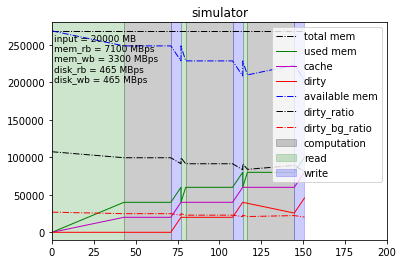

In [8]:
plot.plot_mem_log(mm.get_log(), task_time, "input = %d MB \nmem_rb = %d MBps\nmem_wb = %d MBps \n"
                                           "disk_rb = %d MBps\ndisk_wb = %d MBps"
                  % (input_size, mm.read_bw, mm.write_bw,
                     storage.read_bw, storage.write_bw),
                  xmin=0, xmax=200, ymin=-10000, ymax=280000)